Import libraries:

In [1]:
import seaborn as sns
import numpy as np
import winsound
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

from sklearn.preprocessing import Binarizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import shap

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle

CDFs: 

In [2]:
def ABS_SHAP(df_shap,df):
    
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    corr_list = list()
    
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
        
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

Remove warnings:

In [3]:
import warnings
warnings.filterwarnings('ignore')

Parameters:

In [4]:
clusters_num = 10
estimators_num = 20

Drop list:

In [5]:
dl = ['is_active_flg', 'nps_rating', 'msisdn', 'mcat_business', 'cnt_tp_users', 'tp_group', 'visit_cis_dur_y', 
      'roam_region_cnt_y', 'visit_eur_dur_y', 'visit_ame_dur_y', 'visit_other_dur_y', 'region', 'sex', 'clc_all_cnt_q',
      'in_sms_cnt_q', 'sales_channel', 'con_typ', 'pmnt_cnt_q', 'avg_pmnt_amount_q', 'viruchay_cnt_q']

Import data:

In [8]:
df = pd.read_csv('data/critics_clients_join.csv') 
df = df[df['is_active_flg']==1]
df['score'] = df['nps_rating']

df.drop(dl, axis=1, inplace=True)
df.dropna(inplace=True)
df.iloc[:,:8].head()

,active_days,all_call_dur_q,data_tot_mb_q,pmnt_amount_y,pmnt_cnt_y,all_call_cnt_q,cnt_block_q,dur_block_q
0,5241,10414,0.0,300.0,3,94,0,0
1,5030,165703,14853.0,37700.0,16,1727,0,0
2,6579,74892,32745.0,11670.0,31,386,3,1614
3,4979,19515,0.0,850.0,3,124,0,0
4,1442,108686,85866.0,8273.0,44,1619,0,0


Features:

In [9]:
for i in df.columns:
    print('+',i)

+ active_days
+ all_call_dur_q
+ data_tot_mb_q
+ pmnt_amount_y
+ pmnt_cnt_y
+ all_call_cnt_q
+ cnt_block_q
+ dur_block_q
+ age
+ avg_balance_q
+ score


Encode categorial features:

In [11]:
# cat_features = ['sex'] 
# df[cat_features] = df[cat_features].applymap(lambda x: hash(x) % 100)

Number of columns/rows:

In [10]:
print('Number of records:', len(df))

Number of records: 124214


#### NPS prediction

Prepare data:

In [12]:
array = df.values
X = array[:,0:(len(df.columns)-1)]
Y = array[:,(len(df.columns)-1)].reshape(-1, 1).astype(int)
Y = Binarizer(threshold=np.median(df['score'])).fit(Y).transform(Y).ravel()
Y = np.where(Y==1, 0, 1)

Compare classes of algos:

In [13]:
scoring='accuracy'

models, results = [], []
names = []

models.append(('GBC', GradientBoostingClassifier(n_estimators=estimators_num, random_state=7))) 
models.append(('LR', LogisticRegression(solver='newton-cg')))

for name, model in models:
    
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

GBC: 0.592880 (0.003846)
LR: 0.594740 (0.003717)


Ensemble test:

In [14]:
scoring='accuracy'
kfold = KFold(n_splits=10, random_state=7)

estimators = []
estimators.append(('GBC', GradientBoostingClassifier(n_estimators=estimators_num, random_state=7))) 
estimators.append(('LR', LogisticRegression(solver='newton-cg')))

ensemble = VotingClassifier(estimators, voting='hard')
cv_results = cross_val_score(ensemble, X, Y, cv=kfold, scoring=scoring, n_jobs=-1, verbose=1) 
print('%s: %f (%f)' % ('Score', cv_results.mean(), cv_results.std()), '\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.1min remaining:   42.8s


Score: 0.596116 (0.003213) 



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


Bagging test:

In [15]:
scoring='accuracy'
kfold = KFold(n_splits=10, random_state=7)

ensemble = GradientBoostingClassifier(n_estimators=estimators_num, random_state=7)
model = BaggingClassifier(base_estimator=ensemble, n_estimators=estimators_num, random_state=7)
cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=-1, verbose=1) 

print('%s: %f (%f)' % ('Score', cv_results.mean(), cv_results.std()), '\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  4.0min remaining:  2.7min


Score: 0.592614 (0.003945) 



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.8min finished


Hold out metrics:

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=7)

model = GradientBoostingClassifier(n_estimators=estimators_num, random_state=7)
model.fit(X_train, Y_train)

predicted = (model.predict_proba(X_test)[:,1] >= 0.5).astype(bool)

precision = float(precision_score(Y_test, predicted))
recall = float(recall_score(Y_test, predicted))
f1 = float(f1_score(Y_test, predicted))

print('Hold-out precision:', round(precision*100), '%')
print('Hold-out recall:', round(recall*100), '%')
print('Hold-out F1:', round(f1*100), '%')

Hold-out precision: 59 %
Hold-out recall: 94 %
Hold-out F1: 73 %


Shap values - first model:

In [17]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

Shap values:

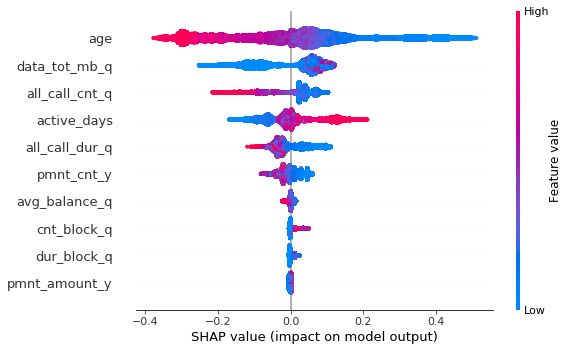

In [19]:
shap.summary_plot(shap_values, X_train, feature_names=df.loc[:, df.columns != 'score'].columns)

Shap value with correlation:

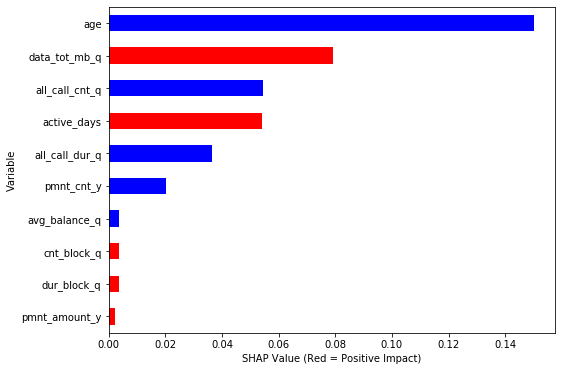

In [20]:
df_train = pd.DataFrame(X_train, columns=df.loc[:, df.columns != 'score'].columns)
ABS_SHAP(shap_values, df_train)

In [21]:
winsound.Beep(440, 1000)

#### Clustering

Feature list:

In [675]:
feature_list = ['msisdn', 'age', 'data_tot_mb_q', 'all_call_cnt_q', 'active_days', 'all_call_dur_q'] 
feature_list.extend(['pmnt_amount_y', 'pmnt_cnt_y', 'avg_balance_q'])

Prepare data:

In [676]:
df_cluster = pd.read_csv('data/critics_clients_join.csv')
df_cluster = df_cluster[df_cluster['is_active_flg']==1]
df_cluster['score'] = df_cluster['nps_rating']

df_cluster = df_cluster[df_cluster['score']<=6]
df_cluster = df_cluster[feature_list]
df_cluster.set_index('msisdn', inplace=True)

df_cluster.dropna(inplace=True)
df_cluster.iloc[:,:].head()

,age,data_tot_mb_q,all_call_cnt_q,active_days,all_call_dur_q,pmnt_amount_y,pmnt_cnt_y,avg_balance_q
msisdn,,,,,,,,
9852209265,38.0,14853.0,1727,5030,165703,37700.0,16,-1107.4928
9151755444,27.0,85866.0,1619,1442,108686,8273.0,44,166.8038
9169689174,34.0,41098.0,1143,3506,494991,28290.0,43,716.3706
9152422345,36.0,26601.0,2134,2772,188232,11179.0,32,698.3362
9162367549,36.0,0.0,706,5321,121174,4000.0,13,711.4600


Rename features:

In [677]:
feature_dict = {'age': 'возраст', 'data_tot_mb_q': 'трафик, гб/кв', 'all_call_cnt_q': 'число звонков, кв'} 
feature_dict.update({'active_days': 'время жизни, лет', 'all_call_dur_q': 'длительность звонков, ч/кв'}) 
feature_dict.update({'pmnt_cnt_y': 'число платежей, год', 'avg_balance_q': 'баланс'})
feature_dict.update({'pmnt_amount_y': 'платежи за год, р'})

df_cluster.rename(feature_dict, axis=1, inplace=True)

df_cluster['трафик, гб/кв'] = df_cluster['трафик, гб/кв']/1000
df_cluster['время жизни, лет'] = df_cluster['время жизни, лет']/365
df_cluster['длительность звонков, ч/кв'] = df_cluster['длительность звонков, ч/кв']/365

Description:

In [678]:
df_cluster.describe().round().astype(int).T

,count,mean,std,min,25%,50%,75%,max
возраст,39337,47,14,3,37,46,57,119
"трафик, гб/кв",39337,16,37,0,0,3,16,2387
"число звонков, кв",39337,610,663,0,194,428,796,13852
"время жизни, лет",39337,11,5,0,7,12,15,24
"длительность звонков, ч/кв",39337,238,256,0,66,164,323,7787
"платежи за год, р",39337,6467,6381,0,2500,5550,8200,187038
"число платежей, год",39337,18,20,0,9,13,21,440
баланс,39337,355,1056,-35449,84,246,502,82372


Add median:

In [679]:
df_median = df_cluster.describe().round().astype(int).loc[['50%'],:].reset_index(drop=True)
df_median['объем кластера']=len(df_cluster)

Within-Cluster-Sum-of-Squares iterations:

In [680]:
X = df_cluster.values 
wcss = []

for i in range(2, clusters_num+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=clusters_num, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    print('Iteration:', i)

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


Plot Within-Cluster-Sum-of-Squares curve: 

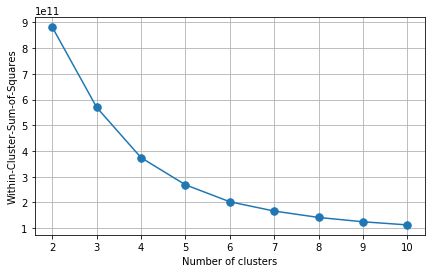

In [681]:
plt.figure(figsize=(7,4))
plt.plot(range(2, clusters_num+1), wcss, '.-', markersize=15)

plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster-Sum-of-Squares')

plt.grid()
plt.show()

Multiple clusters:

In [682]:
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=clusters_num, random_state=0)
cluster_analysis = kmeans.fit_predict(X)

Create cluster dataframe:

In [683]:
df_cluster_profiles = pd.DataFrame(data=kmeans.cluster_centers_, columns=df_cluster.columns)
df_cluster_profiles.index.names = ['#']

Add cluster power:

In [684]:
df_power = pd.DataFrame(dict(Counter(kmeans.labels_)).items(), columns=['#', 'объем кластера'])
df_cluster_power = pd.merge(df_cluster_profiles, df_power, how='inner', on=['#', '#'])
df_cluster_power.drop(['#'], axis=1, inplace=True)
df_cluster_power.iloc[:,:].head(10).T

,0,1,2,3,4,5
возраст,45.598302,46.198276,51.472170,43.516915,43.766867,48.650000
"трафик, гб/кв",19.765076,25.708349,2.441180,29.788111,30.595666,24.574400
"число звонков, кв",610.627839,1653.844828,268.459337,1076.242523,1589.074699,1392.600000
"время жизни, лет",11.403305,13.474764,11.170172,11.518678,11.823882,14.027671
"длительность звонков, ч/кв",240.855291,556.504842,118.231397,397.195631,576.067627,439.223973
"платежи за год, р",6291.484859,45053.405172,1664.776136,11910.782971,21703.908434,112291.300000
"число платежей, год",20.125373,31.241379,9.009445,29.635398,34.382530,28.150000
баланс,344.500340,2156.466365,287.174541,390.487116,655.941858,456.427640
объем кластера,17438.000000,232.000000,13859.000000,6127.000000,1661.000000,20.000000


Write to csv file:

In [685]:
df_cluster_power.to_excel('data/profiles.xlsx', sheet_name='First', index=True)
df_cluster_power_norm = df_cluster_power.div(df_median.iloc[0], axis='columns')

Show profiles:

In [686]:
df_cluster_power_norm.head(10)

,возраст,"трафик, гб/кв","число звонков, кв","время жизни, лет","длительность звонков, ч/кв","платежи за год, р","число платежей, год",баланс,объем кластера
0,0.991267,6.588359,1.426701,0.950275,1.468630,1.133601,1.548106,1.400408,0.443298
1,1.004310,8.569450,3.864123,1.122897,3.393322,8.117731,2.403183,8.766123,0.005898
2,1.118960,0.813727,0.627241,0.930848,0.720923,0.299960,0.693034,1.167376,0.352315
3,0.946020,9.929370,2.514585,0.959890,2.421925,2.146087,2.279646,1.587346,0.155757
4,0.951454,10.198555,3.712791,0.985323,3.512607,3.910614,2.644810,2.666430,0.042225
5,1.057609,8.191467,3.253738,1.168973,2.678195,20.232667,2.165385,1.855397,0.000508


Plot cluster profiles:

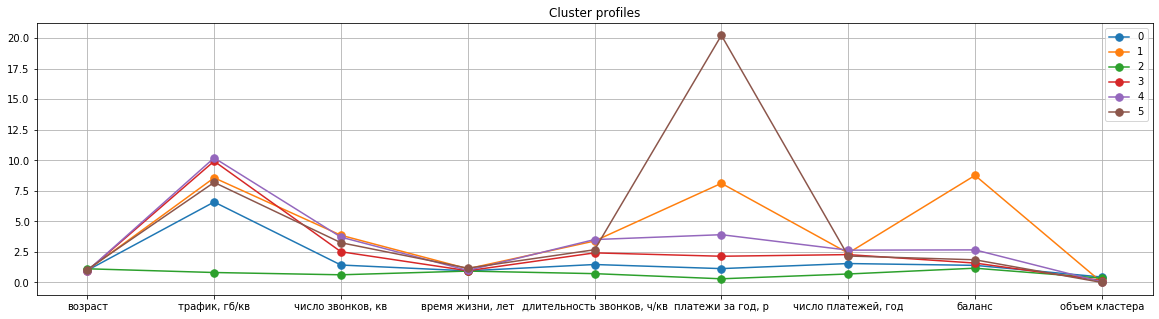

In [687]:
colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plt.figure(figsize=(20,5))

for i in range(6):
    plt.plot(df_cluster_power.columns, df_cluster_power_norm.iloc[i], '.-', markersize=15, color=colors[i], label=(i))  
    
plt.legend(loc='upper right')
plt.title('Cluster profiles')
plt.grid(True)
plt.show()

Merge cluster centers with input dataframe:

In [747]:
cluster_map = pd.DataFrame()
cluster_map['msisdn'] = df_cluster.index.values
cluster_map['cluster'] = kmeans.labels_
df_merged = pd.merge(df_cluster, cluster_map,  how='inner', left_on=['msisdn'], right_on = ['msisdn'])

Write merged dataframe:

In [748]:
df_merged.to_excel('data/cluster_msisdn.xlsx', sheet_name='First', index=True)

Add dashboard features: 

In [749]:
df_dash = pd.read_csv('data/train_test.csv')
df_dash = df_dash[df_dash['business_dt']=='2019-05-31']

df_dash = df_dash[df_dash['nps_rating']<=6]

del df_dash['business_dt']
del df_dash['nps_rating']
del df_dash['device_cur']

feature_dict = {'arpu_avg_hy1': 'arpu, р', 'had_financial_block_hy1': 'наличие блокировок'} 
feature_dict.update({'tp_med_age_d': 'возраст тарифа, дни', 'call_outcountry_cnt_y': 'число звонков зарубеж'}) 
feature_dict.update({'ppd_daily_charge_rur_hy1': 'ppd списания, руб', 'complaint_cnt_hy1': 'число жалоб'})
feature_dict.update({'ppd_cnt_hy1': 'число ppd'})

df_dash.rename(feature_dict, axis=1, inplace=True)
df_dash.iloc[:,:].head()

,msisdn,"arpu, р",наличие блокировок,"ppd списания, руб","возраст тарифа, дни",число звонков зарубеж,число жалоб,число ppd
1,9162199066,708.808370,0,15,188.48103,0,0,6
2,9153238646,583.541677,0,48,618.73730,0,0,6
3,9163335500,1247.783305,0,0,323.79626,1,0,6
12,9104837565,674.833333,1,0,500.64780,0,0,0
13,9154850363,393.533330,0,0,925.39734,0,0,6


Join cluster data with dash:

In [752]:
df_merged = pd.merge(df_merged, df_dash,  how='inner', left_on=['msisdn'], right_on = ['msisdn'])

Cluster numbers:

In [753]:
list(pd.unique(df_merged[['cluster']].values.ravel('K')))

[1, 0, 4, 3, 2, 5]

In [754]:
df_first = df_merged[df_merged['cluster']==5].describe().round().astype(int)
df_first.drop(['count','mean','std'], inplace=True)
del df_first['msisdn']
del df_first['cluster']
df_first.T.head(100)

,min,25%,50%,75%,max
возраст,24,42,48,56,72
"трафик, гб/кв",1,6,13,39,82
"число звонков, кв",58,663,994,1912,5552
"время жизни, лет",3,11,15,18,22
"длительность звонков, ч/кв",4,223,386,671,1410
"платежи за год, р",80845,87375,105930,117546,187038
"число платежей, год",8,14,21,27,154
баланс,-35449,-4503,2239,7683,25349
"arpu, р",588,6339,7639,10305,17533
наличие блокировок,0,0,0,0,1


In [755]:
df_first.to_excel('data/fifth_describe.xlsx', sheet_name='First', index=True)